<a href="https://colab.research.google.com/github/SammyKen18/SammyKen18/blob/main/RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import google.cloud.bigquery.magics
# Google Auth 
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

In [8]:
%reload_ext google.cloud.bigquery

In [9]:
credentials, your_project_id = google.auth.default(scopes=["https://www.googleapis.com/auth/cloud-platform"])

In [10]:
bqclient = bigquery.Client(credentials=credentials, project="ww-analytics",)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

In [11]:
  
query_string = """
SELECT *
FROM  `ww-analytics.snurmohamed.Eccom_RFM`
"""


In [13]:
dataframe = (
    bqclient.query(query_string)
    .result()
    .to_dataframe()
)

In [14]:
rfm = dataframe

In [15]:
print(rfm.head())

  InvoiceDate    InvoiceNo  ... TotalSum items
0  2021-03-24  48011349835  ...  31.9896    29
1  2021-03-24  48011335837  ...  66.8895    33
2  2021-03-24  48011341290  ...  37.9500    25
3  2021-03-24  48011334637  ...  37.1989    27
4  2021-03-24  48011330115  ...  32.2000    23

[5 rows x 6 columns]


In [2]:
!pip install squarify

In [20]:
# Import libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [16]:
# Convert InvoiceDate from object to datetime format
rfm['InvoiceDate'] = pd.to_datetime(rfm['InvoiceDate'])

In [17]:
# --Group data by customerID--
# Create TotalSum column for online dataset- if data in unit price ad quantity
rfm['TotalSum'] = rfm['TotalSum'] 
# Create snapshot date
snapshot_date = rfm['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)
# Grouping by CustomerID
data_process = rfm.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalSum': 'sum'})
# Rename the columns 
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

2021-03-26 00:00:00


In [18]:
# Print top 5 rows and shape of dataframe
print(data_process.head())
print('{:,} rows; {:,} columns'
  .format(data_process.shape[0], data_process.shape[1]))

                                      Recency  Frequency  MonetaryValue
CustomerID                                                             
00000aeb-7952-4ba1-8887-b7a642a02baa      480          2        25.7400
00012b28-194e-466b-96a7-7d05be5004cf      326          1        26.1600
0001fd97-cf46-4c45-9bbc-ac0210cf7c80      363          1        44.3400
0002008b-85b4-4fb6-a2a8-577b2e380ca0       18          1        53.3898
00020ad3-e214-4c06-a254-8adf555d905e      132          1        12.4498
168,938 rows; 3 columns


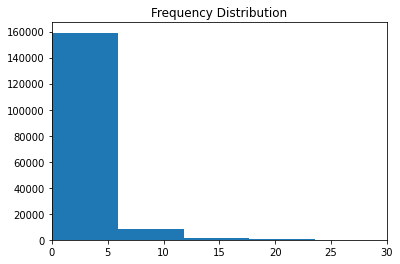

In [35]:
# CREATING FREQUENCY FEATURE ALONG WITH ITS DISTRIBUTION PLOT
frequency  = pd.DataFrame(rfm.groupby('CustomerID').count()['InvoiceNo']).reset_index().rename(columns={'InvoiceNo':'Frequency'})
plt.title('Frequency Distribution')
plt.hist(frequency['Frequency'],bins=10)
plt.xlim(0,30)
plt.show()

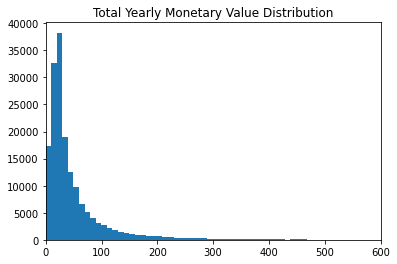

In [38]:
# CREATING MONETARY VALUE FEATURE ALONG WITH ITS DISTRIBUTION PLOT
monetary  = pd.DataFrame(rfm.groupby('CustomerID').sum()['TotalSum']).reset_index().rename(columns={'TotalSum':'Monetary_Value'})
plt.title('Total Yearly Monetary Value Distribution')
plt.hist(monetary['Monetary_Value'],bins=300)
plt.xlim(0,600) # limiting some extreme values for better visualization purposes
plt.show()

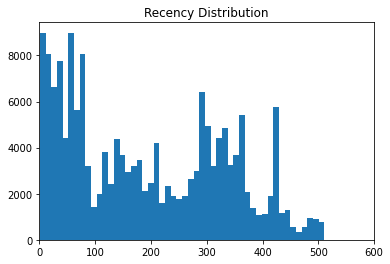

In [44]:
# CREATING FREQUENCY FEATURE ALONG WITH ITS DISTRIBUTION PLOT
Recency  = data_process['Recency']
plt.title('Recency Distribution')
plt.hist(data_process['Recency'],bins=50)
plt.xlim(0,600)
plt.show()

In [50]:
# Merged each dimension and created combined 'rfm' file
data_process.shape

(168938, 3)

In [51]:
data_process.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168938 entries, 00000aeb-7952-4ba1-8887-b7a642a02baa to ffffc06e-94b3-4f3c-bde7-fa08fbe87336
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Recency        168938 non-null  int64  
 1   Frequency      168938 non-null  int64  
 2   MonetaryValue  168938 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 10.2+ MB


In [52]:
# Average of each dimension
data_process.describe().reset_index().iloc[1:2,:]

,index,Recency,Frequency,MonetaryValue
1,mean,191.738999,2.017799,51.848268


In [77]:
rfm = data_process

In [78]:
# 3D Visualization of R-F-M Dimensions
import plotly.express as px
rfm_sample = rfm.sample(frac=0.1,random_state =1234)
fig = px.scatter_3d(rfm_sample, x='Recency', y='Frequency', z='MonetaryValue')

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[0,300],),
                     yaxis = dict(nticks=4, range=[0,10],),
                     zaxis = dict(nticks=4, range=[0,100],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()

In [79]:
# check that Recency is not less than 1 (shouldnt be)
data_process['Recency'].min()

1

In [80]:
# RFM values by each quartile
rfm.describe().reset_index().iloc[3:,:]

,index,Recency,Frequency,MonetaryValue
3,min,1.0,0.0,-0.08
4,25%,59.0,1.0,17.58
5,50%,171.0,1.0,28.33
6,75%,315.0,2.0,56.12
7,max,511.0,59.0,2990.73


In [82]:
rfm['rank'] = rfm['Frequency'].rank(method='first')

In [83]:
rfm['decile'] = pd.qcut(rfm['rank'].values, 10).codes


In [84]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(rfm['decile'], q=4, labels=f_labels)
#df['decile'] = pd.qcut(df['rank'].values, 10).codes
# Create new columns R and F 
rfm = rfm.assign(R = r_groups.values, F = f_groups.values)
rfm.head()


,Recency,Frequency,MonetaryValue,rank,decile,R,F
CustomerID,,,,,,,
00000aeb-7952-4ba1-8887-b7a642a02baa,480,2,25.7400,105596.0,6,1,3
00012b28-194e-466b-96a7-7d05be5004cf,326,1,26.1600,508.0,0,1,1
0001fd97-cf46-4c45-9bbc-ac0210cf7c80,363,1,44.3400,509.0,0,1,1
0002008b-85b4-4fb6-a2a8-577b2e380ca0,18,1,53.3898,510.0,0,4,1
00020ad3-e214-4c06-a254-8adf555d905e,132,1,12.4498,511.0,0,3,1


In [85]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(rfm['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
rfm = rfm.assign(M = m_groups.values)

In [89]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment_Concat'] = rfm.apply(join_rfm, axis=1)
#rfm = rfm.drop(['rank', 'decile'], axis=1)
rfm.head()


,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
CustomerID,,,,,,,
00000aeb-7952-4ba1-8887-b7a642a02baa,480,2,25.7400,1,3,2,132
00012b28-194e-466b-96a7-7d05be5004cf,326,1,26.1600,1,1,2,112
0001fd97-cf46-4c45-9bbc-ac0210cf7c80,363,1,44.3400,1,1,3,113
0002008b-85b4-4fb6-a2a8-577b2e380ca0,18,1,53.3898,4,1,3,413
00020ad3-e214-4c06-a254-8adf555d905e,132,1,12.4498,3,1,1,311


In [90]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

64


In [91]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

CustomerID
00000aeb-7952-4ba1-8887-b7a642a02baa    6
00012b28-194e-466b-96a7-7d05be5004cf    4
0001fd97-cf46-4c45-9bbc-ac0210cf7c80    5
0002008b-85b4-4fb6-a2a8-577b2e380ca0    8
00020ad3-e214-4c06-a254-8adf555d905e    5
Name: RFM_Score, dtype: int64


In [92]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
00000aeb-7952-4ba1-8887-b7a642a02baa,480,2,25.7400,1,3,2,132,6,Potential
00012b28-194e-466b-96a7-7d05be5004cf,326,1,26.1600,1,1,2,112,4,Needs Attention
0001fd97-cf46-4c45-9bbc-ac0210cf7c80,363,1,44.3400,1,1,3,113,5,Promising
0002008b-85b4-4fb6-a2a8-577b2e380ca0,18,1,53.3898,4,1,3,413,8,Champions
00020ad3-e214-4c06-a254-8adf555d905e,132,1,12.4498,3,1,1,311,5,Promising


In [93]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue       
                      mean      mean          mean  count
RFM_Level                                                
Can't Loose Them     107.4       3.8         108.0  56445
Champions            151.6       1.4          37.2  20368
Loyal                166.8       1.2          28.3  23632
Needs Attention      348.3       1.0          14.6  14525
Potential            200.9       1.0          22.8  24515
Promising            288.8       1.0          18.8  21746
Require Activation   394.1       1.0           7.6   7707


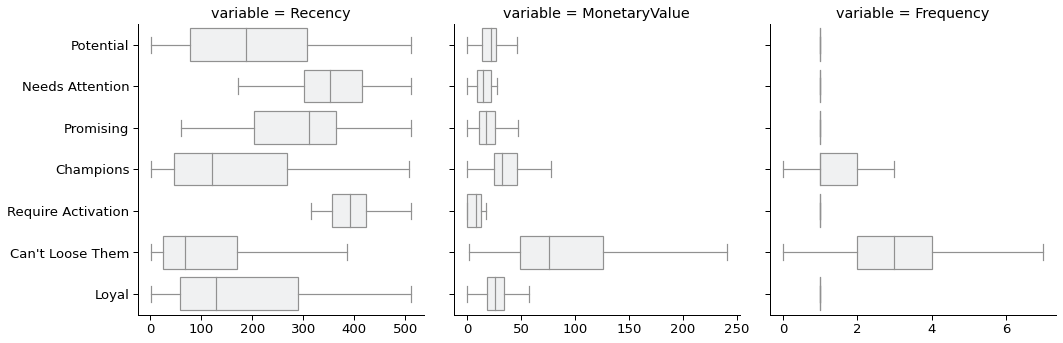

In [94]:
features = ['Recency','MonetaryValue','Frequency','RFM_Level']
summary = rfm[features].melt(id_vars=['RFM_Level']) 

sns.set_context(context = 'paper',font_scale=1.5)
g = sns.FacetGrid(summary, col="variable",sharex=False,height=5)
g.map_dataframe(sns.boxplot, x="value", y="RFM_Level",hue='variable',showfliers=False)

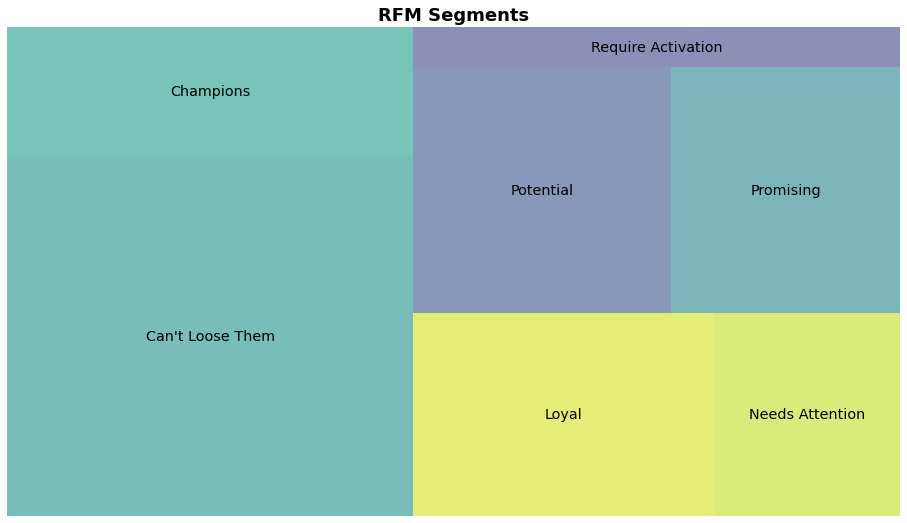

In [132]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
#https://towardsdatascience.com/treemap-basics-with-python-777e5ed173d0

#import plotly.express as px
#fig = px.treemap(df, 
                # path=['Platform', 'Genre'], 
                 #values='Global_Sales',
                 #color='NA_Sales'
                #)
#fig.show()